In [36]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [37]:
ignore = ['TroponinI', 'Fibrinogen', 'EtCO2', 'Bilirubin_direct']
ignore_mice_A = ['Unit2']

In [38]:
def SIRS(row):
    sirs = ['HR', 'Temp', 'PaCO2', 'Resp', 'WBC']
    counter_sirs = 0
    if row['HR'] > 90:
        counter_sirs +=1
    if row['Temp'] < 36 or row['Temp'] > 38:
        counter_sirs += 1
    if row['PaCO2'] < 32 or row['Resp'] > 20:
        counter_sirs += 1
    if row['WBC'] > 12000 or row['WBC'] < 4000:
        counter_sirs += 1
    return counter_sirs


def transform_data_with_SIRS(df):
    """
    Returns the whole df if the patient didn't have sepsis (and label 0), or the truncated df if the patient had sepsis
    (up until the first row with SepsisLabel=1, and label 1). In addition create new SIRS column - count the creiteria number
    """
    
    df['SIRS'] = df.apply(SIRS, axis=1)
    
    if df['SepsisLabel'].sum() == 0:
        return df.drop(columns='SepsisLabel').drop(columns=ignore), 0
    ind = df.SepsisLabel.where(df.SepsisLabel == 1).first_valid_index()
    return df.drop(columns='SepsisLabel').drop(columns=ignore).loc[0:ind], 1

# Mean imputation

In [39]:
X_train = []
Y_train = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_train.append(mean_data)
    Y_train.append(label)
all_data_means = pd.concat(X_train).reset_index(drop=True)

In [40]:
# leave one column of unit and impute by most frequent value
all_data_means = all_data_means.drop(columns='Unit2')
most_freq_unit = all_data_means['Unit1'].value_counts().index[0]
all_data_means['Unit1'] = all_data_means['Unit1'].fillna(most_freq_unit)
# mean imputation to all other columns
mean_imp = all_data_means.mean()
all_data_means = all_data_means.fillna(all_data_means.mean())
X_train_min = all_data_means.min()
X_train_max = all_data_means.max()
all_data_means = (all_data_means - X_train_min) / (X_train_max - X_train_min)
all_data_means

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,0.198012,0.962592,0.620491,0.466528,0.218877,0.098121,0.394059,0.490327,0.373927,0.006829,...,0.326577,0.084840,0.053219,0.031506,0.729412,0.0,0.0,0.870497,0.152239,0.192308
1,0.487923,0.972603,0.618003,0.395075,0.310945,0.403729,0.334842,0.490327,0.373927,0.007449,...,0.365629,0.084840,0.058665,0.087282,0.770235,0.0,0.0,0.949829,0.005970,0.222222
2,0.402787,0.985220,0.643547,0.385929,0.452912,0.403729,0.251920,0.490327,0.365854,0.007089,...,0.346847,0.084840,0.026341,0.112861,0.523176,1.0,0.0,0.996774,0.149254,0.145833
3,0.489371,0.962818,0.580709,0.462986,0.409216,0.431494,0.300989,0.427143,0.324042,0.007008,...,0.372748,0.097509,0.085741,0.077902,0.754824,0.0,0.0,0.996928,0.080597,0.419753
4,0.330484,0.949264,0.625038,0.343577,0.395930,0.367267,0.272164,0.490327,0.373927,0.007089,...,0.430180,0.084840,0.071227,0.058697,0.517647,1.0,0.0,0.994172,0.131343,0.059259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.223245,0.986522,0.567196,0.318517,0.323051,0.247171,0.282523,0.400000,0.250871,0.007089,...,0.412162,0.291953,0.049724,0.118256,0.669294,1.0,0.0,0.985132,0.101493,0.133333
19996,0.276963,0.955148,0.558923,0.409147,0.441616,0.390509,0.354282,0.490327,0.373927,0.007089,...,0.333333,0.084840,0.044080,0.193785,0.682353,0.0,0.0,0.996079,0.095522,0.161616
19997,0.343449,0.970816,0.638769,0.386110,0.451176,0.403729,0.315677,0.490327,0.365854,0.007089,...,0.409910,0.073024,0.058057,0.108114,0.321647,1.0,0.0,0.996776,0.119403,0.130081
19998,0.232127,0.958904,0.634037,0.547571,0.283146,0.181316,0.240779,0.494286,0.365854,0.007089,...,0.281532,0.039948,0.073108,0.088261,0.644471,1.0,0.0,0.997487,0.104478,0.050505


In [41]:
X_test = []
Y_test = []
for file in os.listdir('../data/test/'):
    df = pd.read_csv(f"../data/test/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_test.append(mean_data)
    Y_test.append(label)
all_data_means_test = pd.concat(X_test).reset_index(drop=True)

In [42]:
all_data_means_test = pd.concat(X_test).reset_index(drop=True)
all_data_means_test=all_data_means_test.drop(columns='Unit2')
all_data_means_test['Unit1'] = all_data_means_test['Unit1'].fillna(most_freq_unit)
all_data_means_test = all_data_means_test.fillna(mean_imp)
all_data_means_test = (all_data_means_test - X_train_min) / (X_train_max - X_train_min)
all_data_means_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,0.206886,0.978474,0.585859,0.647316,0.669730,0.579660,0.318250,0.490327,0.373927,0.007089,...,0.436937,0.084840,0.023653,0.100561,0.505882,0.0,0.0,0.996774,0.041791,0.044444
1,0.263296,0.920548,0.585859,0.568629,0.441005,0.396572,0.342685,0.490327,0.373927,0.007089,...,0.365629,0.084840,0.058665,0.087282,0.788235,0.0,1.0,0.995546,0.044776,0.104167
2,0.190435,0.942808,0.536364,0.455886,0.368179,0.248308,0.340724,0.490327,0.386760,0.007089,...,0.387387,0.092784,0.067733,0.043591,0.804588,1.0,0.0,0.943314,0.059701,0.142857
3,0.372548,0.999473,0.618631,0.400229,0.453126,0.407445,0.345980,0.490327,0.337979,0.006853,...,0.390390,0.038230,0.061461,0.135808,0.284353,0.0,0.0,0.995812,0.080597,0.238095
4,0.378869,0.993322,0.600000,0.396192,0.417749,0.403729,0.262223,0.490327,0.365854,0.006853,...,0.367117,0.063574,0.043811,0.152784,0.102706,1.0,0.0,0.996776,0.122388,0.203252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.324207,0.937072,0.593603,0.485816,0.442821,0.353964,0.281109,0.490327,0.358885,0.007089,...,0.466216,0.038373,0.066926,0.078118,0.579294,1.0,0.0,0.996776,0.128358,0.056911
9996,0.299905,0.969442,0.659933,0.406466,0.396431,0.403729,0.412233,0.360000,0.250871,0.007089,...,0.352853,0.053050,0.058272,0.071860,0.723059,0.0,0.0,0.996776,0.113433,0.213675
9997,0.407953,0.941781,0.686869,0.560922,0.603178,0.502110,0.289593,0.490327,0.373927,0.007089,...,0.365629,0.084840,0.058665,0.087282,0.258824,1.0,0.0,0.995797,0.041791,0.121212
9998,0.442265,0.967861,0.565657,0.508990,0.561517,0.499705,0.352245,0.490327,0.373927,0.007089,...,0.418919,0.038660,0.027416,0.094950,0.552941,1.0,0.0,0.995832,0.038806,0.500000


## KNN - Mean Imputation

### Training - Grid Search

In [46]:
f1_scores = {'A':[], 'B':[], 'C':[]}

ignore_B = ['Lactate', 'SaO2', 'BaseExcess', 'Alkalinephos', 'Bilirubin_total', 'AST']
ignore_C = ['FiO2', 'PaCO2', 'pH', 'HCO3', 'PTT']
ignores = {'A': None, 'B':ignore_B, 'C':[*ignore_B, *ignore_C]}

n_neighbors = None
ignore_type=None

score = 0

for ig_key in ['A', 'B', 'C']:
    for k in range(1,25):
        nbrs = KNeighborsClassifier(n_neighbors=k)
        if ig_key == 'A':
            nbrs.fit(all_data_means, Y_train)
            y_pred = nbrs.predict(all_data_means_test)
        else:
            nbrs.fit(all_data_means.drop(columns=ignores[ig_key]), Y_train)
            y_pred = nbrs.predict(all_data_means_test.drop(columns=ignores[ig_key]))
        new_score = f1_score(Y_test, y_pred)
        f1_scores[ig_key].append(new_score)
        if new_score > score:
            score = new_score
            n_neighbors = k
            ignore_type = ig_key
        
print('f1 test score:', score)
print(f"n_neighbors={n_neighbors}, ignore_type={ignore_type}")

f1 test score: 0.3681592039800995
n_neighbors=3, ignore_type=C


### Final Model

In [47]:
nbrs =  KNeighborsClassifier(n_neighbors=n_neighbors)
if ignore_type == 'A':
    nbrs.fit(all_data_means, Y_train)
    y_pred = nbrs.predict(all_data_means_test)
else:
    nbrs.fit(all_data_means.drop(columns=ignores[ignore_type]), Y_train)
    y_pred = nbrs.predict(all_data_means_test.drop(columns=ignores[ignore_type]))
test_f1_score = f1_score(Y_test, y_pred)
test_acuuracy = accuracy_score(Y_test, y_pred)
test_recall = recall_score(Y_test, y_pred)

print(f"KNN with mean imputation and SIRS (n_neighbors = {n_neighbors}), ignore_type={ignore_type}")
print(f"F1 score: {test_f1_score}, test acuracy: {test_acuuracy}, recall: {test_recall}")

KNN with mean imputation and SIRS (n_neighbors = 3), ignore_type=C
F1 score: 0.3681592039800995, test acuracy: 0.9365, recall: 0.2496626180836707


### Analysis

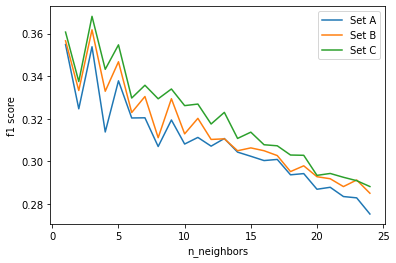

In [48]:
x = range(1,25)
plt.plot(x, f1_scores['A'], label = "Set A")
plt.plot(x, f1_scores['B'], label = "Set B")
plt.plot(x, f1_scores['C'], label = "Set C")
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('f1 score')
plt.show()